<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/05__Dropout_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dropout rate 변화

✅ 실험 설계

목적: Dropout 비율 변화에 따른 모델(MPL, CNN) 학습 안정성 및 일반화 성능 비교

데이터: MNIST (28x28 흑백 이미지)

모델: MLP / CNN

Dropout 비율: 0.0, 0.25, 0.5, 0.75

평가: 최종 테스트 정확도 + 학습/테스트 정확도 추이

In [1]:
# ===========================
# 0. 라이브러리 임포트
# ===========================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# ===========================
# 1. 데이터셋 준비
# ===========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.23MB/s]


- MNIST (손글씨 숫자 0~9) 사용

- transforms.Normalize((0.5,), (0.5,)) → 평균 0, 표준편차 1에 가깝게 정규화

In [3]:
# =====================================
# 2. 모델 정의 (Dropout 비율 조정 가능)
# =====================================
class MLP(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.fc(x)

class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(dropout_rate/2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 128), nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

- conv1 → ReLU → MaxPool

- conv2 → ReLU → MaxPool

- fc1 (128차원) → Dropout 적용 → fc2 (10클래스)

- Dropout은 nn.Dropout(dropout_rate) 로 지정

In [4]:
# ===========================
# 3. 학습 & 평가 함수
# ===========================
def train_and_evaluate(model, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_list, test_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            loss = criterion(model(data), target)
            loss.backward()
            optimizer.step()

        # 평가
        model.eval()
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for data, target in trainloader:
                data, target = data.to(device), target.to(device)
                pred = model(data).argmax(dim=1)
                correct_train += (pred == target).sum().item()
                total_train += target.size(0)
            for data, target in testloader:
                data, target = data.to(device), target.to(device)
                pred = model(data).argmax(dim=1)
                correct_test += (pred == target).sum().item()
                total_test += target.size(0)

        train_acc_list.append(correct_train/total_train)
        test_acc_list.append(correct_test/total_test)

    return train_acc_list, test_acc_list

- 손실 함수: CrossEntropyLoss

- 최적화: Adam(lr=0.001)

- 3 epoch 동안 학습 (실험용으로 빠르게 확인 가능)

In [5]:
# ===========================
# 4. 실험 실행
# ===========================
dropout_rates = [0.0, 0.25, 0.5, 0.75]
results = {}

for rate in dropout_rates:
    results[f"MLP_{rate}"] = train_and_evaluate(MLP(dropout_rate=rate))
    results[f"CNN_{rate}"] = train_and_evaluate(CNN(dropout_rate=rate))

- Dropout Rate을 [0.0, 0.2, 0.5, 0.7] 로 변경하면서 결과 비교

- 각 실험마다 Test Accuracy 출력

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


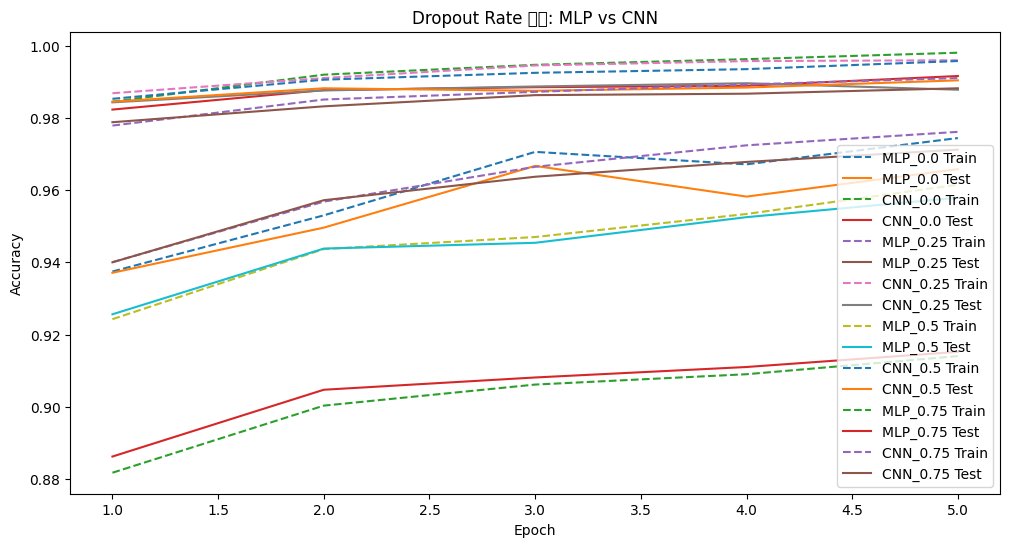

In [6]:
# ===========================
# 5. 시각화
# ===========================
import matplotlib.pyplot as plt

epochs = range(1, 6)

plt.figure(figsize=(12,6))
for k, (train_acc, test_acc) in results.items():
    plt.plot(epochs, train_acc, '--', label=f"{k} Train")
    plt.plot(epochs, test_acc, '-', label=f"{k} Test")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Dropout Rate 비교: MLP vs CNN")
plt.legend()
plt.show()